In [1]:
!pip install tensorflow matplotlib scikit-learn

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
# Root folder with subfolders 0,1,2,...,9
DATA_DIR = r"C:\Users\samin\Desktop\humanActivity\handwritenDigits"

IMG_HEIGHT = 28
IMG_WIDTH  = 28
NUM_CLASSES = 10

print("Using dataset from:", DATA_DIR)


Using dataset from: C:\Users\samin\Desktop\humanActivity\handwritenDigits


In [4]:
X = []
y = []

for label in range(NUM_CLASSES):
    class_dir = os.path.join(DATA_DIR, str(label))
    if not os.path.isdir(class_dir):
        print("Missing folder:", class_dir)
        continue

    for fname in os.listdir(class_dir):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        fpath = os.path.join(class_dir, fname)
        img = load_img(fpath, color_mode="grayscale",
                       target_size=(IMG_HEIGHT, IMG_WIDTH))
        arr = img_to_array(img) / 255.0    # (28,28,1), normalize
        X.append(arr)
        y.append(label)

X = np.array(X, dtype="float32")  # (N, 28, 28, 1)
y = np.array(y, dtype="int")

print("Image tensor shape:", X.shape)   # (N, 28, 28, 1)
print("Labels shape:", y.shape)


Image tensor shape: (21555, 28, 28, 1)
Labels shape: (21555,)


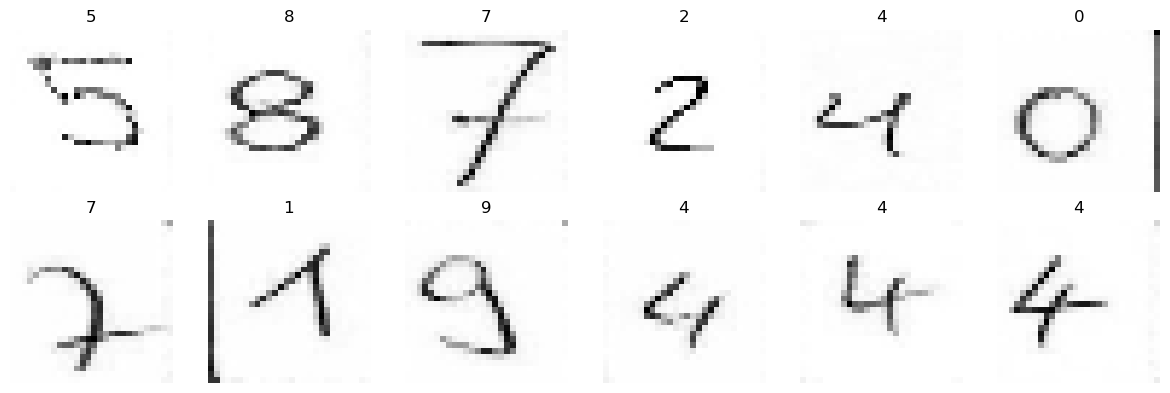

In [5]:
def show_samples(X, y, n=12):
    plt.figure(figsize=(12, 4))
    idxs = np.random.choice(len(X), size=n, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(2, n//2, i+1)
        plt.imshow(X[idx].squeeze(), cmap="gray")
        plt.title(int(y[idx]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(X, y, n=12)


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# For MLP: flatten (N, 784)
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

# One-hot labels for MLP/CNN
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat   = to_categorical(y_val, NUM_CLASSES)
y_test_cat  = to_categorical(y_test, NUM_CLASSES)

print("Flattened input shape:", X_train_flat.shape)


Train: (15088, 28, 28, 1) Val: (3233, 28, 28, 1) Test: (3234, 28, 28, 1)
Flattened input shape: (15088, 784)


In [7]:
def build_mlp(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

input_dim = X_train_flat.shape[1]  # should be 784
mlp = build_mlp(input_dim, NUM_CLASSES)
mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history_mlp = mlp.fit(
    X_train_flat, y_train_cat,
    validation_data=(X_val_flat, y_val_cat),
    epochs=20,
    batch_size=128,
    verbose=1
)


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.1147 - loss: 2.3413 - val_accuracy: 0.1587 - val_loss: 2.2746
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1658 - loss: 2.2333 - val_accuracy: 0.2388 - val_loss: 2.1504
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2116 - loss: 2.1313 - val_accuracy: 0.2725 - val_loss: 2.0685
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1947 - loss: 2.1313 - val_accuracy: 0.2459 - val_loss: 2.0557
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2027 - loss: 2.1133 - val_accuracy: 0.2561 - val_loss: 1.9998
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2212 - loss: 2.0737 - val_accuracy: 0.2867 - val_loss: 2.0457
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2269 - loss: 2.0713 - val_accuracy: 0.3313 - val_loss: 1.9369
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2430 - loss: 2.0402 - val_accu

MLP Test Accuracy: 0.3494


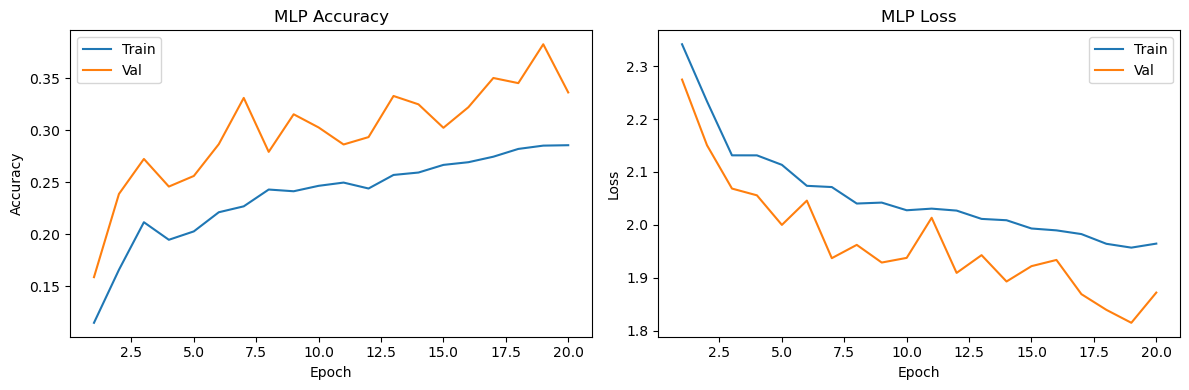

In [9]:
# Evaluation
mlp_loss, mlp_acc = mlp.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"MLP Test Accuracy: {mlp_acc:.4f}")

# Training curves
epochs = range(1, len(history_mlp.history["loss"]) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_mlp.history["accuracy"], label="Train")
plt.plot(epochs, history_mlp.history["val_accuracy"], label="Val")
plt.title("MLP Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_mlp.history["loss"], label="Train")
plt.plot(epochs, history_mlp.history["val_loss"], label="Val")
plt.title("MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


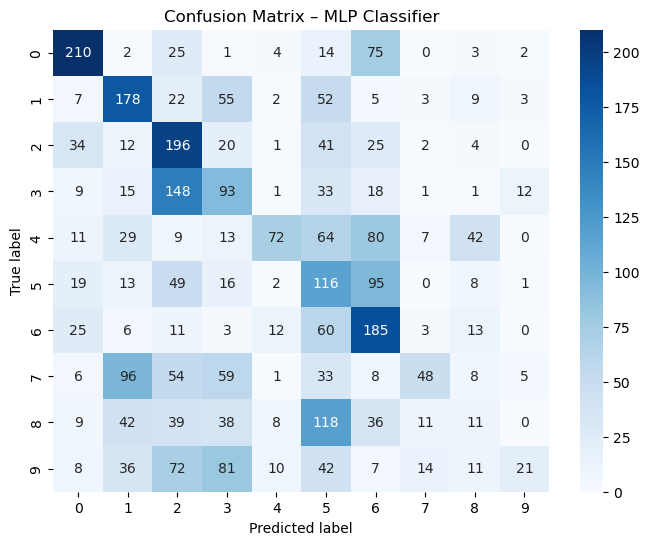

Classification report (MLP):
              precision    recall  f1-score   support

           0     0.6213    0.6250    0.6231       336
           1     0.4149    0.5298    0.4654       336
           2     0.3136    0.5851    0.4083       335
           3     0.2454    0.2810    0.2620       331
           4     0.6372    0.2202    0.3273       327
           5     0.2024    0.3636    0.2601       319
           6     0.3464    0.5818    0.4343       318
           7     0.5393    0.1509    0.2359       318
           8     0.1000    0.0353    0.0521       312
           9     0.4773    0.0695    0.1214       302

    accuracy                         0.3494      3234
   macro avg     0.3898    0.3442    0.3190      3234
weighted avg     0.3910    0.3494    0.3232      3234



In [22]:
import seaborn as sns  # if not already imported

# Predictions from MLP on test set (flattened)
mlp_pred_prob = mlp.predict(X_test_flat)
mlp_pred = np.argmax(mlp_pred_prob, axis=1)

# Confusion matrix
cm_mlp = confusion_matrix(y_test, mlp_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – MLP Classifier")
plt.show()

print("Classification report (MLP):")
print(classification_report(y_test, mlp_pred, digits=4))


In [11]:
def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn = build_cnn()
cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,410 (1.49 MB)

 Trainable params: 390,410 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_cnn = cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=128,
    verbose=1
)


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.3593 - loss: 1.8000 - val_accuracy: 0.7544 - val_loss: 0.7808
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8035 - loss: 0.6348 - val_accuracy: 0.8998 - val_loss: 0.3133
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8951 - loss: 0.3445 - val_accuracy: 0.9347 - val_loss: 0.2084
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9229 - loss: 0.2526 - val_accuracy: 0.9412 - val_loss: 0.1813
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9378 - loss: 0.1979 - val_accuracy: 0.9595 - val_loss: 0.1277
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9534 - loss: 0.1527 - val_accuracy: 0.9654 - val_loss: 0.1102
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9603 - loss: 0.1306 - val_accuracy: 0.9703 - val_loss: 0.1002
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9678 - loss: 0.1104 - val_acc

CNN Test Accuracy: 0.9827


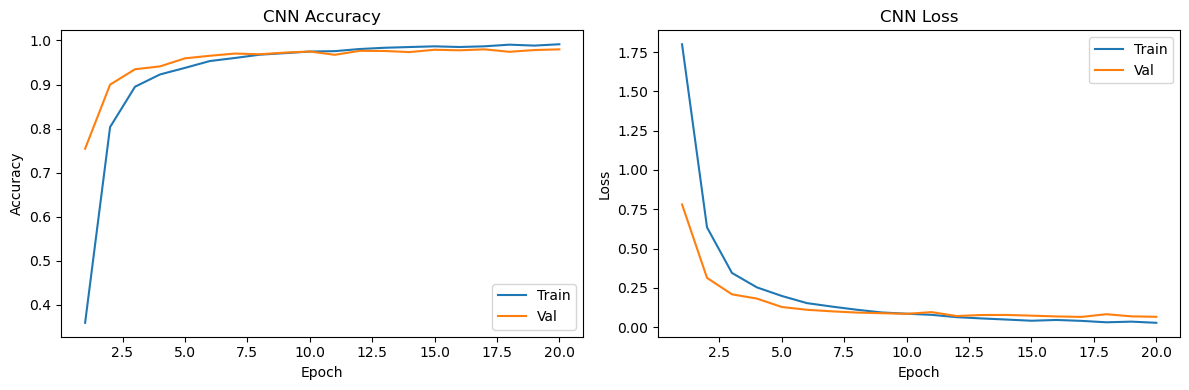

In [13]:
cnn_loss, cnn_acc = cnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")

epochs = range(1, len(history_cnn.history["loss"]) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_cnn.history["accuracy"], label="Train")
plt.plot(epochs, history_cnn.history["val_accuracy"], label="Val")
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_cnn.history["loss"], label="Train")
plt.plot(epochs, history_cnn.history["val_loss"], label="Val")
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


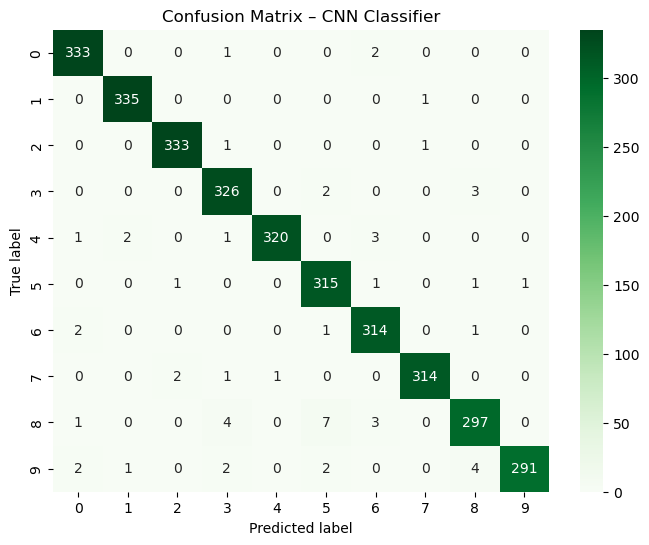

Classification report (CNN):
              precision    recall  f1-score   support

           0     0.9823    0.9911    0.9867       336
           1     0.9911    0.9970    0.9941       336
           2     0.9911    0.9940    0.9925       335
           3     0.9702    0.9849    0.9775       331
           4     0.9969    0.9786    0.9877       327
           5     0.9633    0.9875    0.9752       319
           6     0.9721    0.9874    0.9797       318
           7     0.9937    0.9874    0.9905       318
           8     0.9706    0.9519    0.9612       312
           9     0.9966    0.9636    0.9798       302

    accuracy                         0.9827      3234
   macro avg     0.9828    0.9823    0.9825      3234
weighted avg     0.9828    0.9827    0.9827      3234



In [21]:
import seaborn as sns  # safe to leave here too

# Predictions from CNN on test set (images, not flattened)
cnn_pred_prob = cnn.predict(X_test)
cnn_pred = np.argmax(cnn_pred_prob, axis=1)

# Confusion matrix
cm_cnn = confusion_matrix(y_test, cnn_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – CNN Classifier")
plt.show()

print("Classification report (CNN):")
print(classification_report(y_test, cnn_pred, digits=4))


In [15]:
LATENT_DIM = 32

def build_autoencoder(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, latent_dim=LATENT_DIM):
    # ===========================
    # Encoder (2x downsampling)
    # Input: 28x28x1  →  7x7x64
    # ===========================
    enc_inputs = keras.Input(shape=(img_height, img_width, 1), name="ae_input")

    x = enc_inputs  # assume X already in [0,1], no extra normalization here
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)  # 28 -> 14

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)  # 14 -> 7

    # remember shape for decoder
    shape_before_flatten = keras.backend.int_shape(x)[1:]  # (h, w, c)
    h, w, c = shape_before_flatten
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    encoder = keras.Model(enc_inputs, latent, name="encoder")

    # ===========================
    # Decoder (2x upsampling)
    # Latent  →  7x7x64  →  28x28x1
    # ===========================
    dec_inputs = keras.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(h * w * c, activation="relu")(dec_inputs)
    x = layers.Reshape((h, w, c))(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)  # 7 -> 14
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)  # 14 -> 28

    dec_outputs = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

    decoder = keras.Model(dec_inputs, dec_outputs, name="decoder")

    # Full autoencoder
    ae_outputs = decoder(encoder(enc_inputs))
    autoencoder = keras.Model(enc_inputs, ae_outputs, name="autoencoder")

    return encoder, decoder, autoencoder


encoder, decoder, autoencoder = build_autoencoder()
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       119,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       159,169 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,369 (1.06 MB)

 Trainable params: 278,369 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_ae = autoencoder.fit(
    X_train, X_train,   # input = target
    validation_data=(X_val, X_val),
    epochs=15,
    batch_size=128,
    verbose=1
)


Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0352 - val_loss: 0.0241
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 9/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 10/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 11/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 12/15
118/118 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


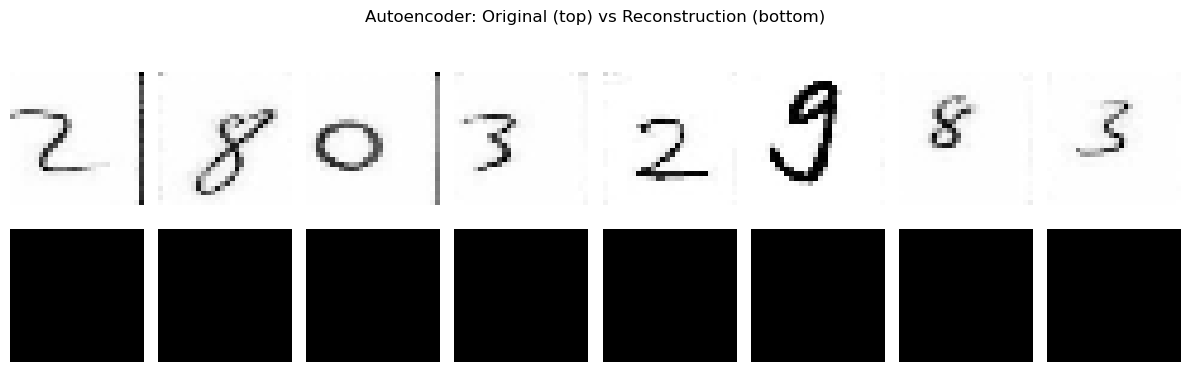

In [17]:
# take some test images
n = 8
samples = X_test[:n]
recons = autoencoder.predict(samples)

plt.figure(figsize=(12, 4))
for i in range(n):
    # original
    plt.subplot(2, n, i+1)
    plt.imshow(samples[i].squeeze(), cmap="gray")
    plt.axis("off")
    # reconstruction
    plt.subplot(2, n, n+i+1)
    plt.imshow(recons[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Autoencoder: Original (top) vs Reconstruction (bottom)")
plt.tight_layout()
plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Latent shape: (3233, 32)
Silhouette score (latent clustering): 0.4772


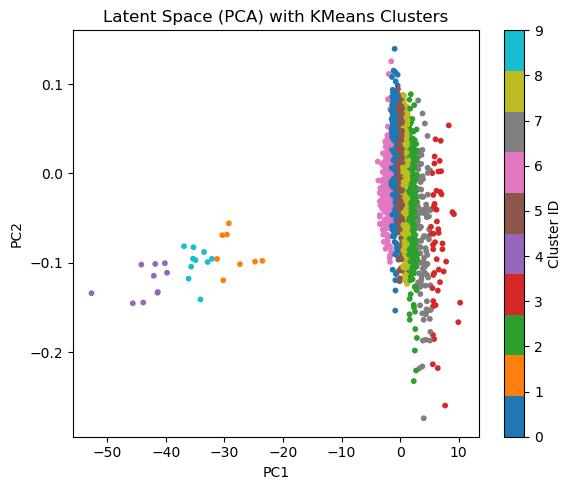

In [18]:
# Get latent vectors for validation set
latents = encoder.predict(X_val)
print("Latent shape:", latents.shape)

# PCA to 2D for visualisation
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(latents)

# KMeans clustering in latent space
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(latents)

sil = silhouette_score(latents, clusters)
print(f"Silhouette score (latent clustering): {sil:.4f}")

plt.figure(figsize=(6,5))
scatter = plt.scatter(Z2[:,0], Z2[:,1], c=clusters, cmap="tab10", s=10)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Latent Space (PCA) with KMeans Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [19]:
# Compute reconstruction error for each validation sample
recons_val = autoencoder.predict(X_val)
errors = np.mean((X_val - recons_val) ** 2, axis=(1,2,3))

threshold = np.percentile(errors, 99)
print("99th percentile threshold:", threshold)
print("Total samples:", len(errors))
print("Anomaly-style samples:", np.sum(errors > threshold))


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
99th percentile threshold: 0.08633685499429701
Total samples: 3233
Anomaly-style samples: 33


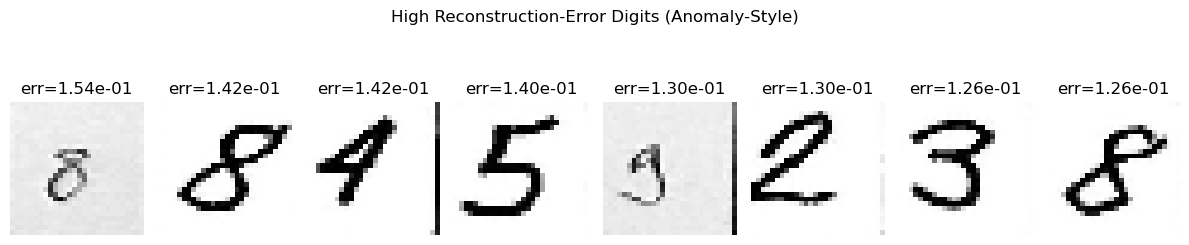

In [20]:
# Indices of highest reconstruction error
n_anom = 8
idxs = np.argsort(-errors)[:n_anom]

plt.figure(figsize=(12,3))
for i, idx in enumerate(idxs):
    plt.subplot(1, n_anom, i+1)
    plt.imshow(X_val[idx].squeeze(), cmap="gray")
    plt.title(f"err={errors[idx]:.2e}")
    plt.axis("off")
plt.suptitle("High Reconstruction-Error Digits (Anomaly-Style)")
plt.tight_layout()
plt.show()
